In [1]:
#Importing Packages
from sqlalchemy import create_engine
import pandas as pd

In [2]:
#creating connection context
engine = create_engine('postgresql://postgres@sdl53652:5432/postgres')
con = engine.connect()

In [3]:
#Cleanup all the views created
con.execute("""drop view if exists basic_info_view cascade;""")
con.execute("""drop table if exists film_category_new cascade;""")
con.execute("""drop view if exists language_info_view  cascade;""")
con.execute("""drop view if exists release_year_info_view cascade;""")
con.execute("""drop view if exists delivery cascade;""")

In [4]:
#Loading category table from the given csv file
category=pd.read_csv("C:\\Users\\sd186063\\Desktop\\EGC\\Assignments\\summitmedia\\input\\category.csv")
category.to_sql('film_category_new',engine,if_exists='replace')

In [5]:
category

,category_id,name
0,1,Drama
1,2,Animation
2,3,Children
3,4,Classics
4,5,Comedy
5,6,Action
6,7,Documentary
7,8,Games
8,9,Foreign
9,10,Horror


In [6]:
#Views creation
basic_info_view = '''create view basic_info_view 
as
SELECT customer.customer_id, customer.first_name || ' ' || customer.last_name as name, customer.email,
EXTRACT(year FROM age(current_date,create_date))*12 + EXTRACT(month FROM age(current_date,create_date)) as membership_age,city.city,sum(amount) as revenue
FROM customer,address,city,payment
where address.address_id = customer.address_id and address.city_id = city.city_id and customer.customer_id = payment.customer_id group by customer.customer_id, name, customer.email,
membership_age,city.city;'''

language_info_view = '''create view language_info_view 
as
select 	customer_id,
ARRAY_AGG (
       distinct name
    ) preferred_film_language
	
	
from (

WITH cte AS(
select p.customer_id,p.name,p.cnt, row_number() over ( partition by p.customer_id order by p.cnt desc) lang_rank from (

select rental.customer_id,language.name ,count(*) as cnt from inventory, rental,film,language where rental.inventory_id = inventory.inventory_id and film.film_id = inventory.film_id 
and  language.language_id = film.language_id group by rental.customer_id,language.name order by rental.customer_id,cnt desc
) as p
) 
SELECT 
	customer_id, 
	name, 
	cnt,
	lang_rank
FROM 
	cte
WHERE 
	lang_rank <= 5
	) p
	group by customer_id;'''

release_year_info_view = '''create view release_year_info_view 
as
select customer_id,
ARRAY_AGG (
        DISTINCT release_year
    ) preferred_film_year 
	
	
from (
	
WITH cte AS(
	select p.customer_id,p.release,p.cnt, row_number() over ( partition by p.customer_id order by p.cnt desc) year_rank from (

select rental.customer_id,film.release_year as release , count(film.release_year) as cnt from inventory, rental,film where rental.inventory_id = inventory.inventory_id and film.film_id = inventory.film_id 
group by rental.customer_id, film.film_id, film.release_year order by rental.customer_id
) as p
) 
SELECT 
	customer_id, 
	release,
	CASE 
WHEN release > 2010 THEN 'New'
WHEN release > 2000 THEN '00s'
WHEN release > 1990 THEN '90s'
WHEN release < 1990 THEN 'Old'
END AS release_year,
	cnt,
	year_rank
FROM 
	cte
WHERE 
	year_rank <= 2
	) q
	group by customer_id;'''

film_category_info_view = '''create view film_category_info_view 
as
select 	customer_id,
ARRAY_AGG (
        distinct name
      
    ) preferred_film_category
	
	
from (
	
WITH cte AS(
	select p.customer_id,p.name,p.cnt, row_number() over ( partition by p.customer_id order by p.cnt desc) cat_rank from (

select rental.customer_id,film_category_new.name, count(*) as cnt from inventory, rental,film_category,film_category_new where rental.inventory_id = inventory.inventory_id 
and film_category.film_id = inventory.film_id and film_category.category_id=film_category_new.category_id  group by rental.customer_id,film_category_new.name
order by rental.customer_id,cnt desc
) as p
) 
SELECT 
	customer_id, 
	name,
	cnt,
	cat_rank
FROM 
	cte
WHERE 
	cat_rank <= 5
	) p
	group by customer_id;'''

In [7]:
con.execute(basic_info_view)
con.execute(language_info_view)
con.execute(release_year_info_view)
con.execute(film_category_info_view)

In [8]:
#creating final deliverable csv as a view in database
delivery = '''create view delivery
as
select basic_info_view.customer_id, basic_info_view.name, basic_info_view.email, basic_info_view.membership_age, basic_info_view.revenue,language_info_view.preferred_film_language, 
film_category_info_view.preferred_film_category, basic_info_view.city, release_year_info_view.preferred_film_year from basic_info_view, language_info_view, release_year_info_view, 
film_category_info_view where basic_info_view.customer_id=language_info_view.customer_id and basic_info_view.customer_id=release_year_info_view.customer_id and 
basic_info_view.customer_id=film_category_info_view.customer_id;'''
con.execute(delivery)

In [9]:
#import psycopg2
df = pd.read_sql_query('select * from "delivery"',con=engine)
df.to_csv("C:\\Users\\sd186063\\Desktop\\EGC\\Assignments\\summitmedia\\output\\delivery.csv", index = False)

In [13]:
df

,customer_id,name,email,membership_age,revenue,preferred_film_language,preferred_film_category,city,preferred_film_year
0,1,MARY SMITH,MARY.SMITH@sakilacustomer.org,183.0,118.68,[English ],"[Animation, Classics, Comedy, Documentary, Spo...",Sasebo,[00s]
1,2,PATRICIA JOHNSON,PATRICIA.JOHNSON@sakilacustomer.org,183.0,128.73,[English ],"[Animation, Classics, Drama, Horror, Sports]",San Bernardino,[00s]
2,3,LINDA WILLIAMS,LINDA.WILLIAMS@sakilacustomer.org,183.0,135.74,[English ],"[Animation, Comedy, Drama, Sci-Fi, Travel]",Athenai,[00s]
3,4,BARBARA JONES,BARBARA.JONES@sakilacustomer.org,183.0,81.78,[English ],"[Comedy, Documentary, Foreign, Sci-Fi, Travel]",Myingyan,[00s]
4,5,ELIZABETH BROWN,ELIZABETH.BROWN@sakilacustomer.org,183.0,144.62,[English ],"[Animation, Classics, Family, Games, Sports]",Nantou,[00s]
...,...,...,...,...,...,...,...,...,...
594,595,TERRENCE GUNDERSON,TERRENCE.GUNDERSON@sakilacustomer.org,183.0,117.70,[English ],"[Action, Children, Comedy, Documentary, Music]",Jinzhou,[00s]
595,596,ENRIQUE FORSYTHE,ENRIQUE.FORSYTHE@sakilacustomer.org,183.0,96.72,[English ],"[Classics, Foreign, Games, Music, Sports]",Patras,[00s]
596,597,FREDDIE DUGGAN,FREDDIE.DUGGAN@sakilacustomer.org,183.0,99.75,[English ],"[Action, Children, Foreign, Sci-Fi, Sports]",Sullana,[00s]
597,598,WADE DELVALLE,WADE.DELVALLE@sakilacustomer.org,183.0,83.78,[English ],"[Comedy, Documentary, Foreign, Games, Horror]",Lausanne,[00s]


# Visualization

In [14]:
import matplotlib.pyplot as plt

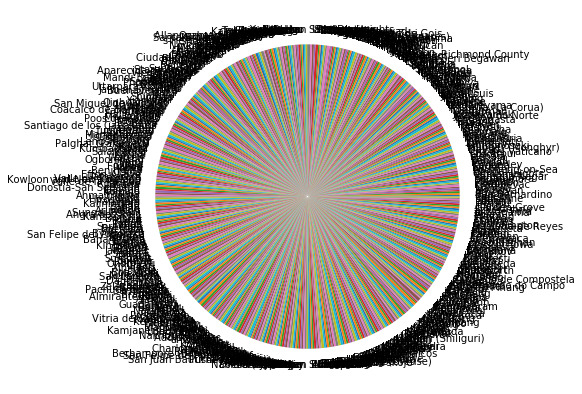

In [70]:
#Ploting pie chart: calculating revenue for each city
fig = plt.figure(figsize = (10,7))
plt.pie(df.revenue, labels = list(df.city))
plt.show()

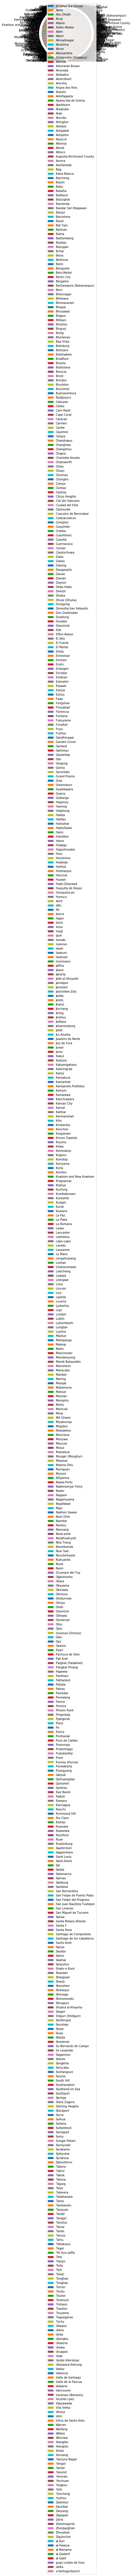

In [85]:
df.groupby(['city']).sum().plot(kind='pie', y = 'revenue')

In [68]:
df.groupby('city')['revenue'].sum()

city
A Corua (La Corua)     107.71
Abha                    96.76
Abu Dhabi              107.68
Acua                   113.74
Adana                  112.74
                        ...  
al-Qadarif              57.81
al-Qatif               110.75
guas Lindas de Gois     93.76
ostka                  103.76
s-Hertogenbosch         90.77
Name: revenue, Length: 597, dtype: float64

In [49]:
df.revenue.sum()

67416.51000000001